This notebook will do a 1day forecast and compare to persistence

Two types of forecast are:
1. Persistence: copy value from today to tomorrow
2. ML applied to features (INCLUDING the emissions from today) to predict the value for tomorrow

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
np.set_printoptions(threshold=10000)
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import seaborn as sns

In [2]:
fires = pd.read_csv('training_data_1day_forecast.csv')
print(fires.columns)
#split date into year/month/day feature
date = fires['Current Day'].values
years = [int(date[i][0:4]) for i in range(len(date))]
months = [int(date[i][5:7]) for i in range(len(date))]
days = [int(date[i][8:10]) for i in range(len(date))]
fires['years'] = years
fires['months'] = months
fires['days'] = days


#get rid of rows which contain nans/zeros for features
inds_features = np.where((fires['biomass_12Z_today']==0)|(fires['biomass_12Z_tomorrow']==0))

fires = fires.drop(labels=inds_features[0], axis=0)


Index(['Incident Number', 'Fire Name', 'Current Day', 'Lat Fire', 'Lon Fire',
       'Number of VIIRS points', 'TLML_12Z', 'QLML_12Z', 'SPEEDLML_12Z',
       'PS_12Z', 'T_12Z_700mb', 'T_12Z_500mb', 'QV_12Z_700mb', 'PBLH_12Z',
       'TCZPBL_12Z', 'precip', 'fccs', 'slp', 'asp', 'ESATLML_12Z', 'ELML_12Z',
       'HDWLML', 'RHLML_12Z', 'Td_12Z_700mb', 'E_700mb', 'HAINES',
       'biomass_12Z_today', 'biomass_12Z_tomorrow'],
      dtype='object')


## Split into features, labels, and persistence forecast

In [3]:
feat_names = []
for name in fires.columns:
    feat_names.append(name)
print(feat_names)
feat_names.remove('Fire Name')
feat_names.remove('Current Day')
feat_names.remove('biomass_12Z_tomorrow')

label_names = ['biomass_12Z_tomorrow']
persistence_names = ['biomass_12Z_today']
print(feat_names, label_names, persistence_names)

features = fires[feat_names]
doot = np.log10(features.loc[:,'biomass_12Z_today'].values)
features.loc[:,'biomass_12Z_today'] = doot
labels = np.log10(fires[label_names]) #turns all the zero values into -inf 
features

# do the train test split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3)
print(x_train.columns)
#print(x_test[persistence_names].values)
y_pred_persistence = x_test.loc[:,persistence_names[0]].values
y_test=y_test.loc[:,'biomass_12Z_tomorrow'].values
print(y_pred_persistence.shape, y_test.shape)
x_train_dropped = x_train.drop(labels=['TLML_12Z', 'Td_12Z_700mb', 'T_12Z_700mb', 'ESATLML_12Z', 'E_700mb', 'QV_12Z_700mb'], axis=1)
x_test_dropped = x_test.drop(labels=['TLML_12Z', 'Td_12Z_700mb', 'T_12Z_700mb', 'ESATLML_12Z', 'E_700mb', 'QV_12Z_700mb'], axis=1)


['Incident Number', 'Fire Name', 'Current Day', 'Lat Fire', 'Lon Fire', 'Number of VIIRS points', 'TLML_12Z', 'QLML_12Z', 'SPEEDLML_12Z', 'PS_12Z', 'T_12Z_700mb', 'T_12Z_500mb', 'QV_12Z_700mb', 'PBLH_12Z', 'TCZPBL_12Z', 'precip', 'fccs', 'slp', 'asp', 'ESATLML_12Z', 'ELML_12Z', 'HDWLML', 'RHLML_12Z', 'Td_12Z_700mb', 'E_700mb', 'HAINES', 'biomass_12Z_today', 'biomass_12Z_tomorrow', 'years', 'months', 'days']
['Incident Number', 'Lat Fire', 'Lon Fire', 'Number of VIIRS points', 'TLML_12Z', 'QLML_12Z', 'SPEEDLML_12Z', 'PS_12Z', 'T_12Z_700mb', 'T_12Z_500mb', 'QV_12Z_700mb', 'PBLH_12Z', 'TCZPBL_12Z', 'precip', 'fccs', 'slp', 'asp', 'ESATLML_12Z', 'ELML_12Z', 'HDWLML', 'RHLML_12Z', 'Td_12Z_700mb', 'E_700mb', 'HAINES', 'biomass_12Z_today', 'years', 'months', 'days'] ['biomass_12Z_tomorrow'] ['biomass_12Z_today']
Index(['Incident Number', 'Lat Fire', 'Lon Fire', 'Number of VIIRS points',
       'TLML_12Z', 'QLML_12Z', 'SPEEDLML_12Z', 'PS_12Z', 'T_12Z_700mb',
       'T_12Z_500mb', 'QV_12Z_700mb

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Train the models

In [8]:
lin_reg = make_pipeline(StandardScaler(), LinearRegression()) #scaling is necessary
lin_reg.fit(x_train, y_train)
y_pred_linreg = lin_reg.predict(x_test)
# perform permutation importance
results = permutation_importance(lin_reg, x_train, y_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature:', feat_names[i], ', Score: %.5f' % (v))
print(y_pred_linreg.shape)

Feature: Incident Number , Score: 0.42812
Feature: Lat Fire , Score: 0.00015
Feature: Lon Fire , Score: 0.01508
Feature: Number of VIIRS points , Score: 0.00073
Feature: TLML_12Z , Score: 25.82146
Feature: QLML_12Z , Score: 1.15135
Feature: SPEEDLML_12Z , Score: 0.00187
Feature: PS_12Z , Score: 0.12223
Feature: T_12Z_700mb , Score: 5.00315
Feature: T_12Z_500mb , Score: 39.65020
Feature: QV_12Z_700mb , Score: 67.31330
Feature: PBLH_12Z , Score: 0.00452
Feature: TCZPBL_12Z , Score: 0.00995
Feature: precip , Score: 0.01497
Feature: fccs , Score: 0.00017
Feature: slp , Score: 0.01413
Feature: asp , Score: 0.00286
Feature: ESATLML_12Z , Score: 1.16230
Feature: ELML_12Z , Score: 2.46997
Feature: HDWLML , Score: 0.00915
Feature: RHLML_12Z , Score: 0.16620
Feature: Td_12Z_700mb , Score: 0.00099
Feature: E_700mb , Score: 66.66945
Feature: HAINES , Score: 0.00259
Feature: biomass_12Z_today , Score: 13.61708
Feature: years , Score: 0.31899
Feature: months , Score: -0.00000
Feature: days , Score: 

In [50]:
lin_reg_dropped = make_pipeline(StandardScaler(), LinearRegression()) #scaling is necessary
lin_reg_dropped.fit(x_train_dropped, y_train)
y_pred_linreg_dropped = lin_reg_dropped.predict(x_test_dropped)
print(y_pred_linreg_dropped.shape)

(1181, 1)


In [9]:
svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)) #scaling is necessary!
svr.fit(x_train, np.ravel(y_train))
y_pred_svr = svr.predict(x_test)
# perform permutation importance
results = permutation_importance(svr, x_train, y_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature:', feat_names[i], ', Score: %.5f' % (v))
print(y_pred_svr.shape)

Feature: Incident Number , Score: 0.08536
Feature: Lat Fire , Score: 0.11359
Feature: Lon Fire , Score: 0.09337
Feature: Number of VIIRS points , Score: 0.12610
Feature: TLML_12Z , Score: 0.10805
Feature: QLML_12Z , Score: 0.15951
Feature: SPEEDLML_12Z , Score: 0.06441
Feature: PS_12Z , Score: 0.09783
Feature: T_12Z_700mb , Score: 0.11506
Feature: T_12Z_500mb , Score: 0.11473
Feature: QV_12Z_700mb , Score: 0.12473
Feature: PBLH_12Z , Score: 0.05520
Feature: TCZPBL_12Z , Score: 0.09092
Feature: precip , Score: 0.07494
Feature: fccs , Score: 0.11410
Feature: slp , Score: 0.10284
Feature: asp , Score: 0.09887
Feature: ESATLML_12Z , Score: 0.12050
Feature: ELML_12Z , Score: 0.15068
Feature: HDWLML , Score: 0.10000
Feature: RHLML_12Z , Score: 0.08647
Feature: Td_12Z_700mb , Score: 0.11706
Feature: E_700mb , Score: 0.12484
Feature: HAINES , Score: 0.08209
Feature: biomass_12Z_today , Score: 9.77687
Feature: years , Score: 0.07682
Feature: months , Score: 0.15466
Feature: days , Score: 0.0552

In [52]:
svr_dropped = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)) #scaling is necessary!
svr.fit(x_train_dropped, np.ravel(y_train))
y_pred_svr_dropped = svr.predict(x_test_dropped)
print(y_pred_svr_dropped.shape)

(1181,)


## Evaluate the models

In [53]:
print(y_pred_linreg.shape, y_pred_svr.shape, y_test.shape)
y_pred_linreg = 10**y_pred_linreg[:,0]
y_pred_linreg_dropped = 10**y_pred_linreg_dropped[:,0]
y_pred_svr = 10**y_pred_svr
y_pred_svr_dropped = 10**y_pred_svr_dropped
y_test = 10**y_test
y_pred_persistence = 10**y_pred_persistence
print(y_pred_linreg.shape, y_pred_svr.shape,y_pred_svr_dropped.shape, y_test.shape, y_pred_persistence.shape)

(1181, 1) (1181,) (1181,)
(1181,) (1181,) (1181,) (1181,) (1181,)


In [54]:
rmse_linreg = np.sqrt(np.mean(((y_pred_linreg)-(y_test))**2))
rmse_linreg_dropped = np.sqrt(np.mean(((y_pred_linreg_dropped)-(y_test))**2))

rmse_svr = np.sqrt(np.mean(((y_pred_svr)-(y_test))**2))
rmse_svr_dropped = np.sqrt(np.mean(((y_pred_svr_dropped)-(y_test))**2))
rmse_persistence = np.sqrt(np.mean(((y_pred_persistence)-(y_test))**2))

print('LinReg RMSE:', rmse_linreg, 'LinReg RMSE Dropped:', rmse_linreg_dropped,'SVR RMSE:', rmse_svr, 'SVR RMSE Dropped:', rmse_svr_dropped, 'persistence RMSE:', rmse_persistence)

LinReg RMSE: 2.6300528652619706e-07 LinReg RMSE Dropped: 2.036106469182915e-07 SVR RMSE: 1.9951499461869208e-07 SVR RMSE Dropped: 1.981022771727103e-07 persistence RMSE: 1.9138537568132405e-07


In [55]:
mad_linreg = np.mean(np.abs(y_pred_linreg-y_test))
mad_svr = np.mean(np.abs(y_pred_svr-y_test))
mad_svr_dropped = np.mean(np.abs(y_pred_svr_dropped-y_test))
mad_persistence = np.mean(np.abs(y_pred_persistence-y_test))

print('LinReg MAD:', mad_linreg, 'SVR MAD:', mad_svr, 'SVR MAD Dropped:', mad_svr_dropped, 'Persistence MAD:', mad_persistence)

LinReg MAD: 8.405394888776171e-08 SVR MAD: 7.251206603112024e-08 SVR MAD Dropped: 7.089509058569762e-08 Persistence MAD: 7.754211234524867e-08


In [56]:
r2_linreg = np.corrcoef(y_pred_linreg, y_test)[0,1]
r2_svr = np.corrcoef(y_pred_svr, y_test)[0,1]
r2_svr_dropped = np.corrcoef(y_pred_svr_dropped, y_test)[0,1]
r2_persistence = np.corrcoef(y_pred_persistence, y_test)[0,1]
print('LinReg R2:', r2_linreg, 'SVR R2:', r2_svr, 'SVR R2 Dropped:', r2_svr_dropped, 'Persistence R2:', r2_persistence)

LinReg R2: 0.6498280110287823 SVR R2: 0.7279104213696166 SVR R2 Dropped: 0.7324475693519328 Persistence R2: 0.7728357229705796


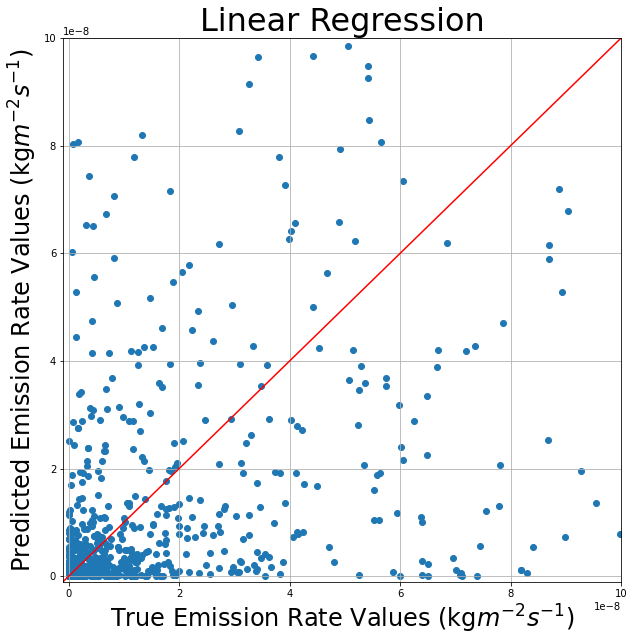

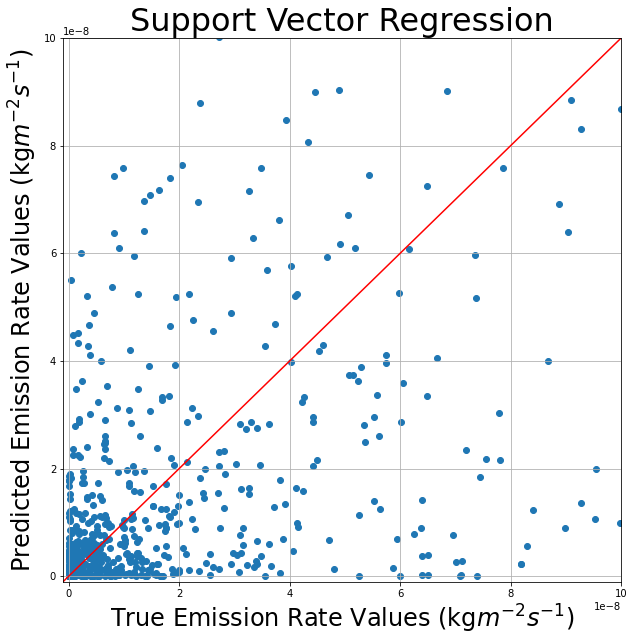

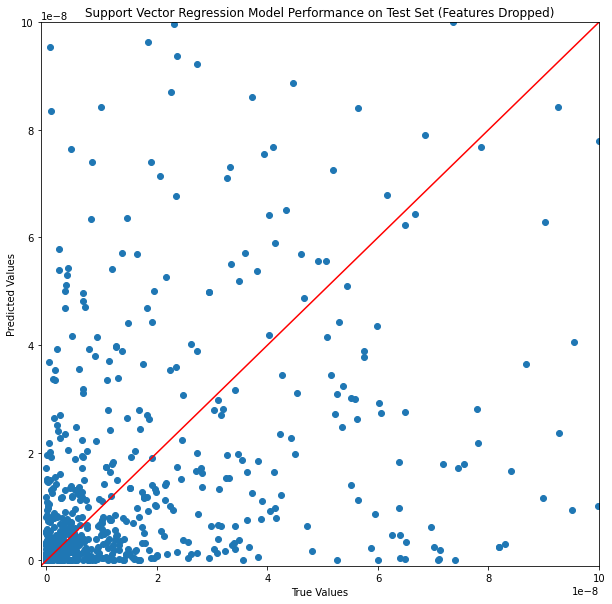

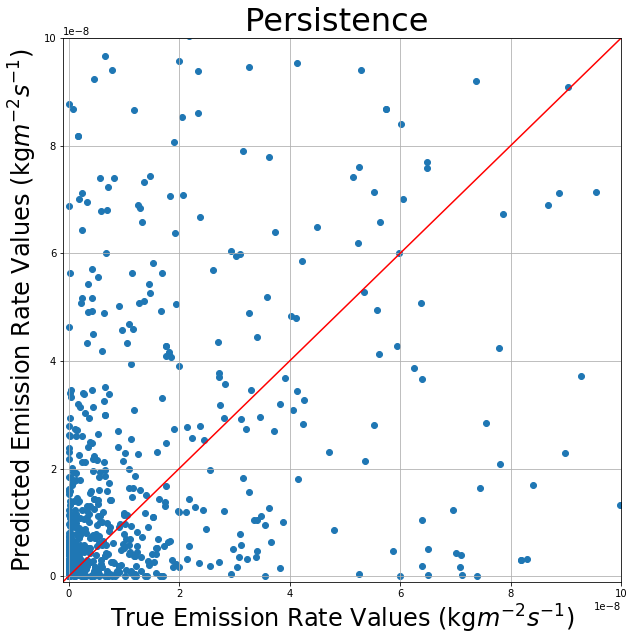

In [57]:
low = -1e-9
high = 1e-7
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_linreg)
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Linear Regression', fontsize=32)
plt.xlabel('True Emission Rate Values (kg$m^{-2}$$s^{-1}$)', fontsize=24)
plt.ylabel('Predicted Emission Rate Values (kg$m^{-2}$$s^{-1}$)', fontsize=24)
plt.xlim([low, high])
plt.ylim([low, high])
plt.grid(True)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_svr)
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Support Vector Regression', fontsize=32)
plt.xlabel('True Emission Rate Values (kg$m^{-2}$$s^{-1}$)', fontsize=24)
plt.ylabel('Predicted Emission Rate Values (kg$m^{-2}$$s^{-1}$)', fontsize=24)
plt.xlim([low, high])
plt.ylim([low, high])
plt.grid(True)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_svr_dropped)
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Support Vector Regression Model Performance on Test Set (Features Dropped)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xlim([low, high])
plt.ylim([low, high])
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_persistence)
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Persistence ', fontsize=32)
plt.xlabel('True Emission Rate Values (kg$m^{-2}$$s^{-1}$)', fontsize=24)
plt.ylabel('Predicted Emission Rate Values (kg$m^{-2}$$s^{-1}$)', fontsize=24)
plt.xlim([low, high])
plt.ylim([low, high])
plt.grid(True)
plt.show()

(array([  73,  146,  159,  255,  289,  315,  333,  378,  382,  432,  532,
        613,  669,  673,  678,  749,  805,  854,  861,  909,  940, 1027,
       1052, 1053, 1054, 1131, 1148, 1150, 1153]),)


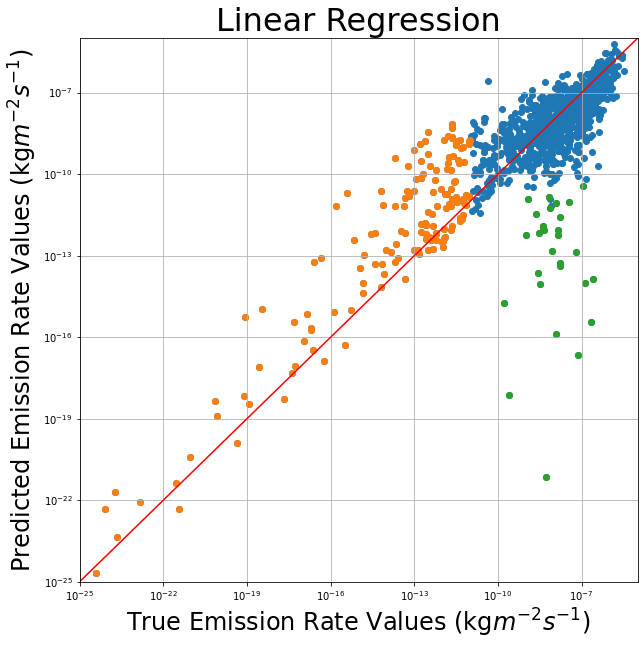

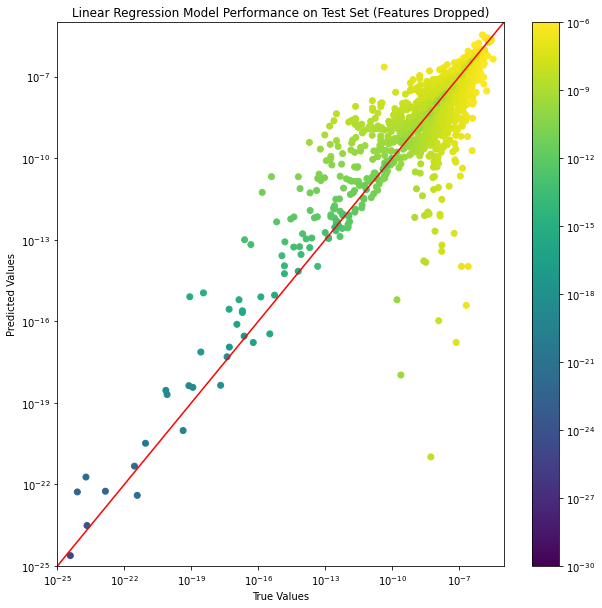

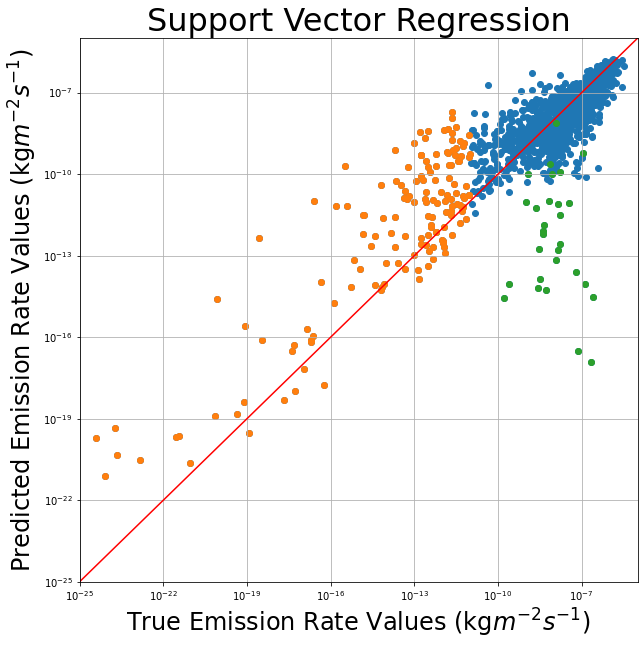

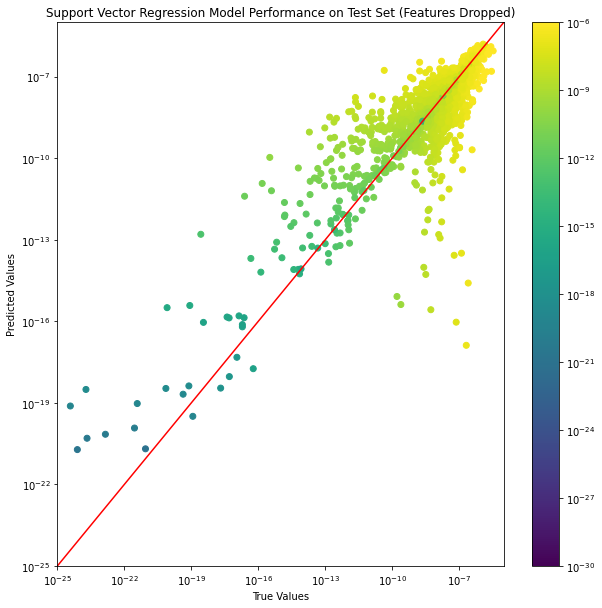

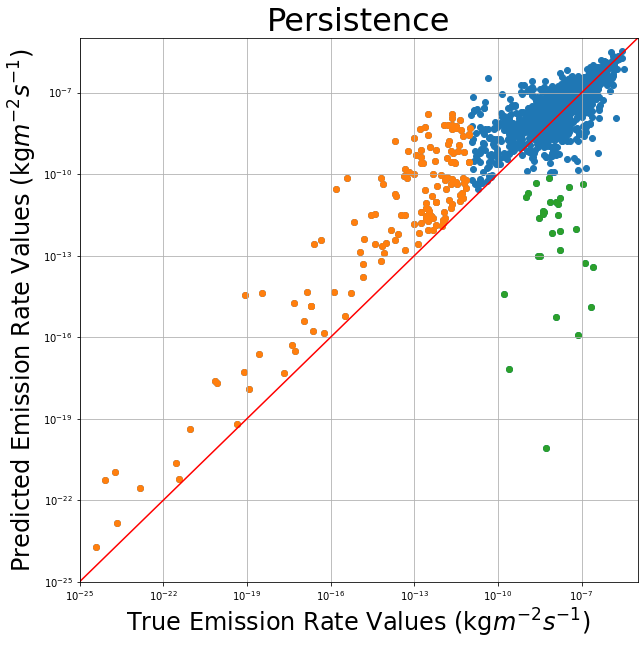

In [58]:
inds_low = np.where(y_test<1e-11)
inds_high = np.where((y_test>1e-10)&(y_pred_persistence>1e-22)&(y_pred_persistence<1e-10))
print(inds_high)
low = 1e-25
high = 1e-5

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_linreg)#, c=np.abs(y_pred_linreg-y_test), norm=matplotlib.colors.LogNorm())
plt.scatter(y_test[inds_low], y_pred_linreg[inds_low])
plt.scatter(y_test[inds_high], y_pred_linreg[inds_high])
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Linear Regression',  fontsize=32)
plt.xlabel('True Emission Rate Values (kg$m^{-2}$$s^{-1}$)', fontsize=24)
plt.ylabel('Predicted Emission Rate Values (kg$m^{-2}$$s^{-1}$)', fontsize=24)
plt.xlim([low, high])
plt.ylim([low, high])
plt.xscale('log')
plt.yscale('log')
#plt.colorbar()
#plt.clim(1e-30,1e-6)
plt.grid(True)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_linreg_dropped, c=np.abs(y_pred_linreg_dropped-y_test), norm=matplotlib.colors.LogNorm())
#plt.scatter(y_test[inds_low], y_pred_linreg_dropped[inds_low])
#plt.scatter(y_test[inds_high], y_pred_linreg_dropped[inds_high])
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Linear Regression Model Performance on Test Set (Features Dropped)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xlim([low, high])
plt.ylim([low, high])
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.clim(1e-30,1e-6)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_svr)#, c=np.abs(y_pred_svr-y_test), norm=matplotlib.colors.LogNorm())
plt.scatter(y_test[inds_low], y_pred_svr[inds_low])
plt.scatter(y_test[inds_high], y_pred_svr[inds_high])
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Support Vector Regression',  fontsize=32)
plt.xlabel('True Emission Rate Values (kg$m^{-2}$$s^{-1}$)', fontsize=24)
plt.ylabel('Predicted Emission Rate Values (kg$m^{-2}$$s^{-1}$)', fontsize=24)
plt.xlim([low, high])
plt.ylim([low, high])
plt.xscale('log')
plt.yscale('log')
#plt.colorbar()
#plt.clim(1e-30,1e-6)
plt.grid(True)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_svr_dropped, c=np.abs(y_pred_svr_dropped-y_test), norm=matplotlib.colors.LogNorm())
#plt.scatter(y_test[inds_low], y_pred_svr_dropped[inds_low])
#plt.scatter(y_test[inds_high], y_pred_svr_dropped[inds_high])
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Support Vector Regression Model Performance on Test Set (Features Dropped)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xlim([low, high])
plt.ylim([low, high])
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.clim(1e-30,1e-6)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_persistence)#, c=np.abs(y_pred_persistence-y_test), norm=matplotlib.colors.LogNorm())
plt.scatter(y_test[inds_low], y_pred_persistence[inds_low])
plt.scatter(y_test[inds_high], y_pred_persistence[inds_high])
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Persistence', fontsize=32)
plt.xlabel('True Emission Rate Values (kg$m^{-2}$$s^{-1}$)', fontsize=24)
plt.ylabel('Predicted Emission Rate Values (kg$m^{-2}$$s^{-1}$)', fontsize=24)
plt.xlim([low, high])
plt.ylim([low, high])
plt.xscale('log')
plt.yscale('log')
#plt.colorbar()
#plt.clim(1e-30,1e-6)
plt.grid(True)
plt.show()

In [ ]:
low = -1e-9
high = 1e-7
plt.figure(figsize=(10,10))
sns.kdeplot(x=y_test, y=y_pred_linreg, shade=True)
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Linear Regression Model Performance on Test Set (Full Range)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xlim([low, high])
plt.ylim([low, high])
plt.show()

plt.figure(figsize=(10,10))
sns.kdeplot(x=y_test, y=y_pred_svr, shade=True)
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Support Vector Regression Model Performance on Test Set (Full Range)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xlim([low, high])
plt.ylim([low, high])
plt.show()

plt.figure(figsize=(10,10))
sns.kdeplot(x=y_test, y=y_pred_svr, shade=True)
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Support Vector Regression Model Performance on Test Set (Features Dropped)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xlim([low, high])
plt.ylim([low, high])
plt.show()

plt.figure(figsize=(10,10))
sns.kdeplot(x=y_test, y=y_pred_persistence, shade=True)
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Persistence Model Performance on Test Set (Full Range)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xlim([low, high])
plt.ylim([low, high])
plt.show()

In [ ]:
def REC(y_pred, y_test):
    percent_error = np.abs((y_pred-y_test)/y_test)*100
    thresholds = np.linspace(0,40000, 8001) #5% increments

    #percent_error = np.abs(y_pred-y_test)
    #thresholds = np.linspace(0, 0.5e-6, 61) #5% increments
    acc = np.zeros(thresholds.shape)
    for ii in range(len(thresholds)):
        n_correct = len(percent_error[percent_error<=thresholds[ii]])
        acc[ii] = n_correct*100/len(y_test)
    return thresholds, acc

# plot REC curve
thresholds_linreg, accuracy_linreg = REC(y_pred_linreg, y_test)
thresholds_svr, accuracy_svr = REC(y_pred_svr, y_test)
print(thresholds_svr[0:5])

thresholds_svr_dropped, accuracy_svr_dropped = REC(y_pred_svr_dropped, y_test)


thresholds_persistence, accuracy_persistence = REC(y_pred_persistence, y_test)

plt.figure(figsize=(10,10))
plt.plot(thresholds_linreg, accuracy_linreg)
plt.plot(thresholds_svr, accuracy_svr)
#plt.plot(thresholds_svr_dropped, accuracy_svr_dropped)
plt.plot(thresholds_persistence, accuracy_persistence)
plt.legend(['Linear Regression', 'SVR', 'Persistence'],fontsize=15)
plt.title('REC Curve for the Methods Tested')
plt.ylabel('Fraction Correct')
plt.xlabel('% Error Tolerance')
plt.show()

In [ ]:
print(len(thresholds_linreg), thresholds_linreg, accuracy_linreg)
print(np.sum(5*accuracy_linreg))
print(np.sum(5*accuracy_svr))
print(np.sum(5*accuracy_svr_dropped))
print(np.sum(5*accuracy_persistence))